# Pretrained Model, classification, Elastic Net

In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/Innolab/Github') 

Mounted at /content/drive


In [2]:
from src.preprocessing.preprocessing_matlab_files import preprocess_mat_files
from src.preprocessing.data_preparation import prepare_data

In [3]:
matlab_dir = "/content/drive/MyDrive/Colab Notebooks/Innolab/Matlab Files" # Enter the directory for the matlab files
excel_path = "/content/drive/MyDrive/Colab Notebooks/Innolab/DELCODE_dataset.xlsx" # Enter the directory for the corresponding excel sheet
write_dir = "/content/drive/MyDrive/Colab Notebooks/Innolab/write" # ...
export_file = False # rename to export file
preprocessing_type = 'aggregation' 

df = preprocess_mat_files(matlab_dir = matlab_dir, excel_path = excel_path, write_dir = write_dir,
                           export_file = export_file, preprocessing_type = preprocessing_type, statistic = 'greater_zero')

loading files
Starting Preprocessing
Creating Final Dataset
Done!


In [4]:
df

,ConnID,Repseudonym,siteid,age,visdat,sex,prmdiag,edyears,MEM_score,Apoe,IDs,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,1_1,1_2,1_3,1_4,1_5,1_6,1_7,2_2,2_3,2_4,2_5,2_6,2_7,3_3,3_4,3_5,3_6,3_7,4_4,4_5,4_6,4_7,5_5,5_6,5_7,6_6,6_7,7_7
0,1,0a8d02f2b,11,66,17.08.2016,0,2,17,0.054016,0.0,1.0,0.565417,0.438914,0.512821,0.490598,0.590909,0.54931,0.514793,0.542735,0.903114,0.923351,0.951961,0.671123,0.806561,0.826923,0.808007,0.964187,0.955556,0.913223,0.657343,0.783217,0.843434,0.962222,0.759091,0.714103,0.903846,0.875,0.822314,0.512238,0.694056,0.727273,0.718935,0.652367,0.662393,0.89645,0.931624,0.91821
1,2,0a71a953d,17,72,30.03.2015,0,1,20,-0.468749,1.0,2.0,0.607495,0.460784,0.515929,0.500855,0.536131,0.434911,0.519724,0.59188,0.880623,0.901961,0.82451,0.522727,0.719457,0.297511,0.55719,0.96786,0.934343,0.884298,0.722611,0.470862,0.645623,0.864444,0.721212,0.507692,0.5,0.537963,0.900826,0.736014,0.624126,0.585859,0.85503,0.387574,0.657051,0.718935,0.647436,0.802469
2,3,0a61339db,11,72,13.05.2015,1,1,16,-0.093521,0.0,3.0,0.628534,0.503771,0.54157,0.578632,0.558275,0.542406,0.610454,0.541311,0.799308,0.672906,0.647059,0.46123,0.649321,0.496606,0.598039,0.947658,0.835354,0.823691,0.600233,0.543124,0.479798,0.848889,0.786364,0.585897,0.710256,0.450926,0.838843,0.501748,0.601399,0.464646,0.745562,0.618343,0.632479,0.689349,0.599359,0.712963
3,4,0b28aed58,17,76,18.01.2016,0,1,20,0.466027,0.0,4.0,0.78501,0.536199,0.302253,0.347009,0.576923,0.548323,0.588757,0.666667,0.930796,0.523173,0.34902,0.589572,0.593891,0.331448,0.601307,0.719927,0.629293,0.698347,0.452214,0.47669,0.380471,0.675556,0.543939,0.382051,0.642308,0.441667,0.72314,0.417832,0.536713,0.487374,0.653846,0.461538,0.57265,0.727811,0.642094,0.743827
4,5,0c1c5ae77,8,64,12.03.2015,1,1,13,1.452099,0.0,5.0,0.682446,0.585219,0.686869,0.624786,0.648019,0.523669,0.623274,0.678775,0.745675,0.468806,0.657843,0.59492,0.536199,0.744344,0.762255,0.831956,0.729293,0.753444,0.460373,0.655012,0.679293,0.837778,0.734848,0.484615,0.902564,0.750926,0.760331,0.43007,0.746503,0.703283,0.659763,0.491124,0.667735,0.91716,0.885684,0.950617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,906,f816d269a,16,84,2017-11-21,2,3,18,-2.388095,0.0,906.0,0.661407,0.535445,0.515929,0.384615,0.624709,0.552268,0.500986,0.628205,0.854671,0.787879,0.766667,0.716578,0.371041,0.669683,0.611928,0.758494,0.743434,0.703857,0.424242,0.652681,0.531145,0.773333,0.584848,0.384615,0.707692,0.476852,0.599174,0.494755,0.58042,0.578283,0.825444,0.531065,0.577991,0.695266,0.668803,0.694444
905,907,f98419539,5,71,2014-09-11,2,3,13,-1.860675,1.0,907.0,0.802104,0.263198,0.637141,0.400855,0.695804,0.572978,0.585799,0.539886,0.83564,0.361854,0.377451,0.163102,0.542986,0.345023,0.449346,0.775023,0.522222,0.782369,0.456876,0.463869,0.51431,0.773333,0.486364,0.485897,0.589744,0.383333,0.855372,0.363636,0.562937,0.609848,0.781065,0.511834,0.606838,0.739645,0.577991,0.694444
906,908,fade343c8,8,78,2015-11-23,2,3,8,-1.868184,1.0,908.0,0.690335,0.427602,0.434343,0.455556,0.545455,0.639053,0.543393,0.58547,0.780277,0.631907,0.609804,0.469251,0.49095,0.464932,0.522059,0.752984,0.675758,0.636364,0.498834,0.441725,0.41835,0.762222,0.540909,0.478205,0.64359,0.512963,0.710744,0.51049,0.43007,0.435606,0.674556,0.454142,0.457265,0.636095,0.639957,0.625
907,909,fbc8a48a0,14,61,2017-03-20,2,3,9,-2.432351,0.0,909.0,0.741617,0.365008,0.717949,0.347863,0.722611,0.731755,0.522682,0.670228,0.678201,0.328877,0.603922,0.390374,0.354072,0.552036,0.409314,0.947658,0.617172,0.913223,0.688811,0.390443,0.302189,0.726667,0.589394,0.369231,0.520513,0.240741,0.859504,0.702797,0.512238,0.395202,0.840237,0.560651,0.719017,0.633136,0.588675,0.759259


In [5]:
classification = True
columns_drop = ["ConnID", "Repseudonym", "siteid", "visdat", "MEM_score", "Apoe", "IDs"]
target = "prmdiag"
y_0 = [0]
y_1 = [2, 3]
train_size = 0.8
seed = 1855
split = True

In [6]:
# preparation of data
ytrain, Xtrain, ytest, Xtest = prepare_data(data = df, classification = classification,
                         columns_drop = columns_drop, target = target, y_0 = y_0, y_1 = y_1,
                         train_size = train_size, seed = seed, split = split)


pd.concat([ytrain, Xtrain], axis = 1) # test data

,y,age,sex,edyears,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,1_1,1_2,1_3,1_4,1_5,1_6,1_7,2_2,2_3,2_4,2_5,2_6,2_7,3_3,3_4,3_5,3_6,3_7,4_4,4_5,4_6,4_7,5_5,5_6,5_7,6_6,6_7,7_7
855,1.0,-0.295663,0.497994,-0.380863,-0.529004,-1.658070,-0.243659,-1.135843,0.112750,-0.507374,-0.470368,-2.311958,0.289465,-1.200514,-0.328841,-1.426494,-0.318062,-0.184575,0.973557,-2.051223,-2.270357,-1.109385,-0.742533,-0.499752,0.284033,-1.193013,-1.319054,-1.371252,-0.027429,-0.474717,0.008656,-0.020551,0.360462,0.192484,-1.284171,-0.446373,-0.432774,-0.447465,-0.965895,0.619472
387,1.0,-0.784678,0.497994,-1.030316,-0.120536,0.191576,0.429930,-0.111948,-0.056319,-0.678802,-1.861097,-1.103816,-2.726578,0.426747,-0.757857,0.294336,-0.631731,-0.710264,-0.801944,-0.338714,-0.784193,-0.080203,-0.431387,-1.256063,-0.398800,-0.456858,-0.289812,0.611438,-0.372083,-1.064865,0.435518,0.461370,-1.809912,-1.008746,-0.414515,-0.619173,-1.464049,-0.487419,-1.130143,-0.619987
857,1.0,0.519362,0.497994,-0.705589,-0.231936,-0.194917,-0.190680,0.226219,-1.127084,0.784927,-0.234651,-0.191373,0.168824,1.282608,0.934375,0.015820,0.037429,-0.936854,-1.240514,1.283662,1.209224,-0.658237,0.530338,-0.955165,-1.222028,0.958823,0.014612,-0.797315,-0.491387,-1.038830,-1.485357,-0.303057,-0.486513,-0.675071,-0.603570,-2.064412,-0.432774,-0.607281,-1.825036,-1.762612
755,1.0,-0.784678,-1.130230,-0.380863,-1.475909,0.985268,0.725098,0.451664,0.042305,0.653060,0.602144,0.771761,1.435562,2.279236,2.427988,2.880554,1.982176,3.658395,3.201774,1.216063,2.579698,1.230946,2.774363,3.720951,3.774776,2.034740,2.247053,2.424556,3.114234,3.890642,0.222087,2.621708,2.971969,2.995354,1.249176,3.418069,2.321337,1.710058,2.824433,1.917030
580,1.0,0.519362,0.497994,-0.380863,0.807802,1.420072,0.717530,1.024669,0.338174,1.457452,1.120721,1.650410,-1.198450,0.528099,0.020728,0.901102,-0.286696,0.712722,0.973557,0.810469,0.960047,1.357831,0.700054,1.883034,1.471013,0.081100,1.913636,0.285338,1.404215,2.068126,0.595590,-0.103641,1.736797,1.326979,-0.338892,0.339083,0.185991,0.711205,1.358839,0.658205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.0,-1.599703,0.497994,-0.380863,-0.937473,1.054284,1.164066,0.066529,-0.295832,0.099216,-1.507522,-0.225167,-0.816417,-1.341281,-1.441106,-0.869462,0.643855,-0.519928,0.527913,0.923134,0.168019,1.653897,-1.138538,-0.841312,-0.973145,1.043764,-0.043373,-0.823403,0.436530,-0.413967,1.716101,-1.782058,-1.598168,-1.542626,-0.376704,-0.069354,0.440777,-0.127832,-0.081485,-0.581254
339,0.0,0.030347,0.497994,-0.705589,0.343633,-0.443377,-0.251227,1.588281,0.211373,-0.982097,1.262151,-0.757425,-1.479947,0.263458,0.116065,-0.451689,0.832057,0.060143,0.450102,0.292210,0.417197,0.667011,0.539767,-1.800932,-1.719794,1.157018,1.217811,1.837575,-0.199756,-0.492075,0.542233,-0.020551,-1.068809,-1.631606,-0.452326,0.747520,0.064664,1.710058,1.308302,0.522639
200,0.0,-0.947683,0.497994,0.593317,0.306500,1.330351,2.420422,2.189467,2.169747,0.653060,1.556797,0.095877,0.309572,1.029228,1.013822,2.432939,0.372009,2.443871,1.808254,0.517540,1.502897,1.371930,1.058344,1.679725,0.947721,0.619059,1.986118,0.624482,1.006536,-0.249073,1.662743,-0.053787,0.783950,-0.530478,-0.338892,1.957122,1.423521,0.231755,0.765021,1.200468
148,1.0,0.193352,-1.130230,1.567496,0.622135,0.232986,0.376951,-0.421934,0.535420,-1.338139,-0.175722,-0.106888,-1.158236,-1.313128,-1.758896,-0.252749,1.177093,0.187033,0.273260,-2.456817,-0.419327,-0.954303,-1.383683,0.451736,-0.354129,-2.155676,-0.159344,-2.271289,-0.743250,-0.283787,-2.072291,-1.898384,-0.839420,-0.775173,1.702909,-0.933355,-0.893815,-1.526226,-0.940626,-2.111210


# Train Model
Evaluate AUC and accuracy on test data

In [ ]:
from src.models.pipeline_elastic_net import model_elastic_net
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
model = model_elastic_net(X_train = Xtrain, y_train = ytrain, 
                          classification = True, 
                          n_alphas_logreg = 10, 
                          l1_ratios_logreg= np.linspace(0,  1, 11).tolist(), 
                          cv_logreg = 5,
                          max_iter = 500) 

In [ ]:
predictions = model.predict(Xtest)
accuracy_score(ytest, predictions)

0.7553191489361702

In [ ]:
pred_prob = model.predict_proba(Xtest)
auc = roc_auc_score(ytest, pred_prob[:, 1])
auc

0.8111888111888111

In [6]:
model.l1_ratio_

array([0.8])

In [ ]:
model.C_

array([0.35938137])

# Save Model

In [7]:
import pickle

In [ ]:
filename ='pretrained_elnet_class_agg_zero.sav'
pickle.dump(model, open(filename, 'wb'))

# Evaluation

In [8]:
# load model
model = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Innolab/pretrained_elnet_class_agg_zero.sav", 'rb'))

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

In [ ]:
predictions = model.predict(Xtest)

In [ ]:
 precision_score(ytest, predictions)

0.82

In [ ]:
recall_score(ytest, predictions)

0.7454545454545455

In [ ]:
f1_score(ytest, predictions)

0.780952380952381

# Visualisation coefficients

In [4]:
from src.visualization.viz_utils import plot_coef_elastic_net

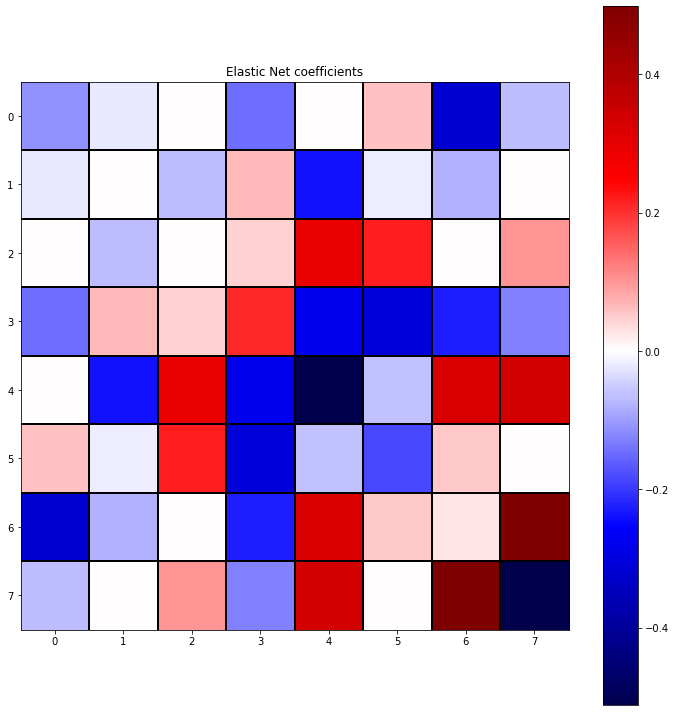

In [5]:
plot_coef_elastic_net(model)

# Feature importance

In [9]:
from src.visualization.viz_utils import plot_grouped_FI
from src.visualization.group_imp import grouped_permutation_FI, group_only_permutation_FI

In [10]:
  ind_conn_cols = []
  for x in range(len(model.feature_names_in_)):
    if len(model.feature_names_in_[x].split("_"))>1 and model.feature_names_in_[x].split("_")[0].isdigit() and model.feature_names_in_[x].split("_")[1].isdigit():
      ind_conn_cols.append(x)

In [11]:
groups_df = pd.DataFrame({'conn_name': model.feature_names_in_[ind_conn_cols], 'region': model.feature_names_in_[ind_conn_cols]})

In [19]:
df_importance = grouped_permutation_FI(model, Xtest, ytest, groups_df, m = 10)

In [20]:
df_importance.head()

,region,mean decrease accuracy
0,0_0,0.005319
1,0_1,-0.001064
2,0_2,0.000000
3,0_3,-0.013830
4,0_4,0.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


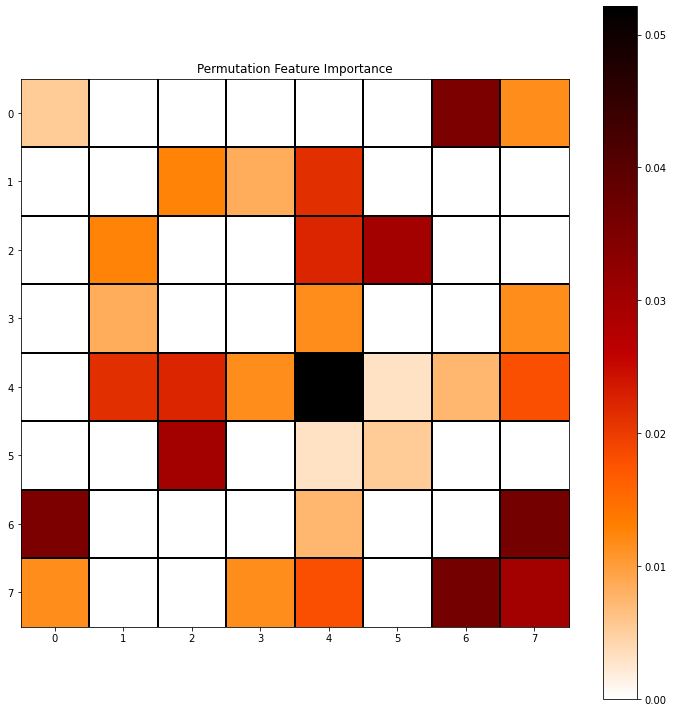

In [21]:
plot_grouped_FI(df_importance, title = "Permutation Feature Importance")

In [25]:
df_importance_only = group_only_permutation_FI(model, Xtest, ytest, groups_df, m = 10)

In [26]:
df_importance_only.head()

,region,mean decrease accuracy
0,0_0,-1.110223e-17
1,0_1,1.063830e-03
2,0_2,0.000000e+00
3,0_3,8.510638e-03
4,0_4,0.000000e+00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


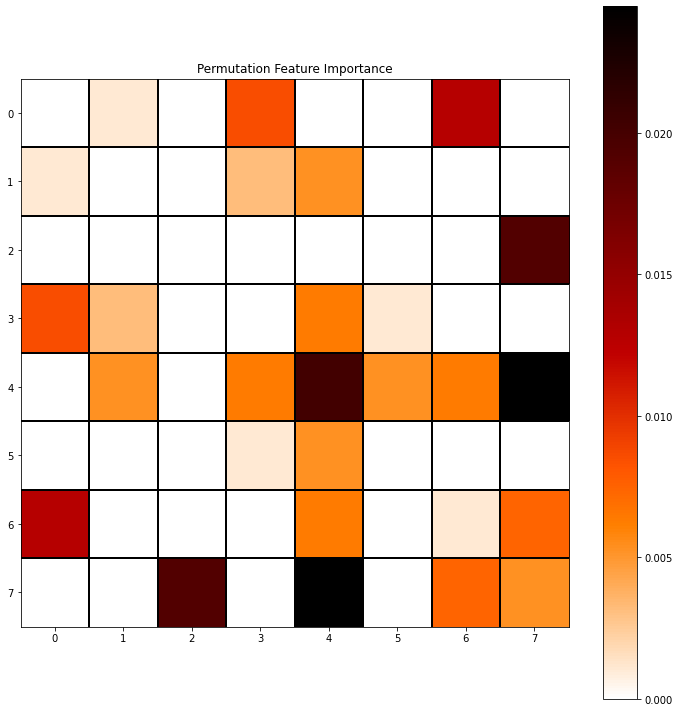

In [27]:
plot_grouped_FI(df_importance_only, title = "Permutation Feature Importance")